### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer (1 input channel, 32 output channels, kernel size 7, stride 1, padding 1)
        self.conv1 = nn.Conv1d(1, 32, 7, 1, 1)

        # Second convolutional layer (32 input channels, 32 output channels, kernel size 5, stride 2, padding 1)
        self.conv2 = nn.Conv1d(32, 32, 5, 2, 1)

        # Third convolutional layer (32 input channels, 32 output channels, kernel size 3, stride 2, no padding)
        self.conv3 = nn.Conv1d(32, 32, 3, 2, 0)
        # Layer normalization for the output of the third convolutional layer
        self.norm3 = nn.LayerNorm([32, 91])

        # Fourth convolutional layer (64 input channels, 128 output channels, kernel size 3, stride 1, padding 1)
        self.conv4 = nn.Conv1d(32, 32, 3, 2, 0)
        # Layer normalization for the output of the fourth convolutional layer
        self.norm4 = nn.LayerNorm([32, 45])

        # Fifth convolutional layer (32 input channels, 256 output channels, kernel size 3, stride 1, padding 1)
        self.conv5 = nn.Conv1d(32, 256, 3, 1, 1)
        # Layer normalization for the output of the fifth convolutional layer
        self.norm5 = nn.LayerNorm([32, 22])

        # Flattened size after convolution and pooling (256 output channels * 22 width)
        self.flattened_size = 256 * 22
        # First fully connected layer (from flattened size to 22 units)
        self.fc1 = nn.Linear(self.flattened_size, 22)

        # Second fully connected layer (22 input units to 5 output units)
        self.fc2 = nn.Linear(22, 5)

        # Average pooling layers (kernel size 2, stride 2)
        self.avg1 = torch.nn.AvgPool1d(2, stride=2)
        self.avg2 = torch.nn.AvgPool1d(2, stride=2)
        self.avg3 = torch.nn.AvgPool1d(2, stride=2)

    def forward(self, x):
        # Apply first convolutional layer followed by ReLU activation
        x1 = F.relu(self.conv1(x))
        # Apply average pooling after the first convolutional layer
        x1a = self.avg1(x1)

        # Apply second convolutional layer followed by ReLU activation and add residual connection (x1a)
        x2 = F.relu(self.conv2(x1)) + x1a
        # Apply average pooling after the second convolutional layer
        x2a = self.avg2(x2)

        # Apply third convolutional layer with layer normalization followed by ReLU and add residual connection (x2a)
        x3 = F.relu(self.conv3(self.norm3(x2))) + x2a
        # Apply average pooling to further downsample the output of the third layer
        x3a = self.avg1(x3)

        # Apply fourth convolutional layer with layer normalization followed by ReLU and add residual connection (x3a)
        x4 = F.relu(self.conv4(self.norm4(x3))) + x3a

        # Apply fifth convolutional layer with layer normalization followed by ReLU activation
        x5 = F.relu(self.conv5(self.norm5(x4)))

        # Flatten the output of the fifth convolutional layer for input into fully connected layers
        x5_flat = x5.view(x5.size(0), -1)

        # Apply first fully connected layer followed by ReLU activation
        f1 = F.relu(self.fc1(x5_flat))

        # Apply second fully connected layer to produce final output
        z = self.fc2(f1)

        return z


In [ ]:
#debug your network here
#make sure it works
model=Net()
#x=torch.rand(10,187)
x=torch.rand(10,1,187)
z=model(x)
print(z.shape)

torch.Size([10, 5])


In [ ]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [ ]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0])
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)
    return acc, sens, prec

## The function to train the model

In [ ]:
def train(model, device, optimizer, dataloader, epoch):
    model.train()#set model to training mode
    loss_train=0
    acc_train =0
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset)
    acc_train/=sample_count
    return loss_train, acc_train

## The Function to test the model

In [ ]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders
### You may need to edit MyDataset

In [ ]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        x=x.reshape(1,-1)
        return x, y

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Attention: this dataset does not have class-imbalance issue.

In [ ]:
import pandas as pd

# Load the ECG data with the specified adjustments
X = pd.read_csv('/content/drive/MyDrive/HW#4_CSC_546/ECG_dataX.csv', header=None, skiprows=1)
Y = pd.read_csv('/content/drive/MyDrive/HW#4_CSC_546/ECG_dataY.csv', header=None, skiprows=1)


In [ ]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [ ]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [ ]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

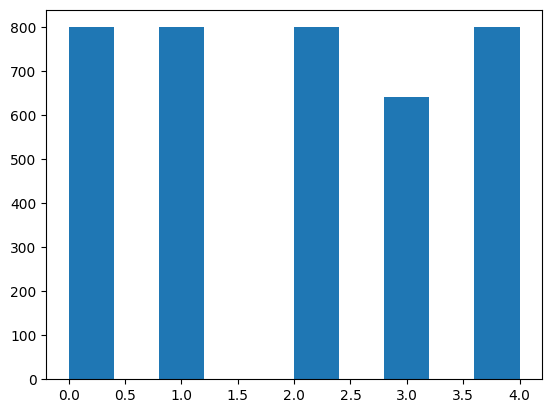

In [ ]:
plt.hist(Y)

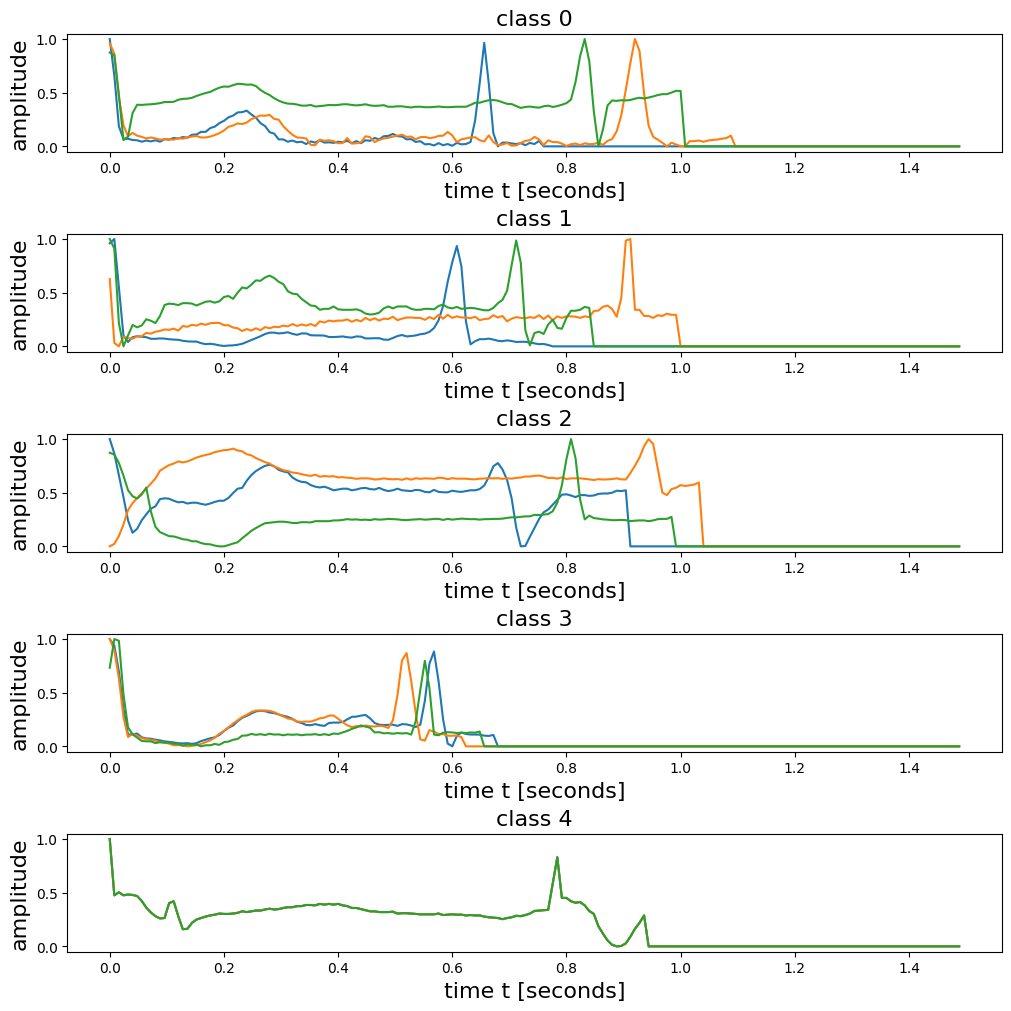

In [ ]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [ ]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [ ]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0)
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0)

## Create a model, and start the traning-validation-testing process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
z=model(x)

In [ ]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.2045, 0.1889, 0.2107, 0.2074, 0.1885]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [ ]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [ ]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list,
              acc_val_list, other_val)
    #change the name of the file if necessary
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 1.612959
epoch 0 training loss: 1.1193804361603477 acc: 0.5767004341534009
epoch 0 validation acc: 0.6850649
saved: ECG_MLP_Pytorch_epoch0.pt
Train Epoch: 1 [0%]	Loss: 0.697219
epoch 1 training loss: 0.7266684933142229 acc: 0.7442112879884226
epoch 1 validation acc: 0.737013
saved: ECG_MLP_Pytorch_epoch1.pt
Train Epoch: 2 [0%]	Loss: 0.617345
epoch 2 training loss: 0.6061197492209348 acc: 0.7756874095513748
epoch 2 validation acc: 0.76623374
saved: ECG_MLP_Pytorch_epoch2.pt
Train Epoch: 3 [0%]	Loss: 0.592257
epoch 3 training loss: 0.5298634185032411 acc: 0.808972503617945
epoch 3 validation acc: 0.78571427
saved: ECG_MLP_Pytorch_epoch3.pt
Train Epoch: 4 [0%]	Loss: 0.535213
epoch 4 training loss: 0.4946409287777814 acc: 0.8176555716353111
epoch 4 validation acc: 0.78246754
saved: ECG_MLP_Pytorch_epoch4.pt
Train Epoch: 5 [0%]	Loss: 0.437343
epoch 5 training loss: 0.45108901912515814 acc: 0.8368306801736614
epoch 5 validation acc: 0.8019481
saved: ECG_MLP_Pytorch_

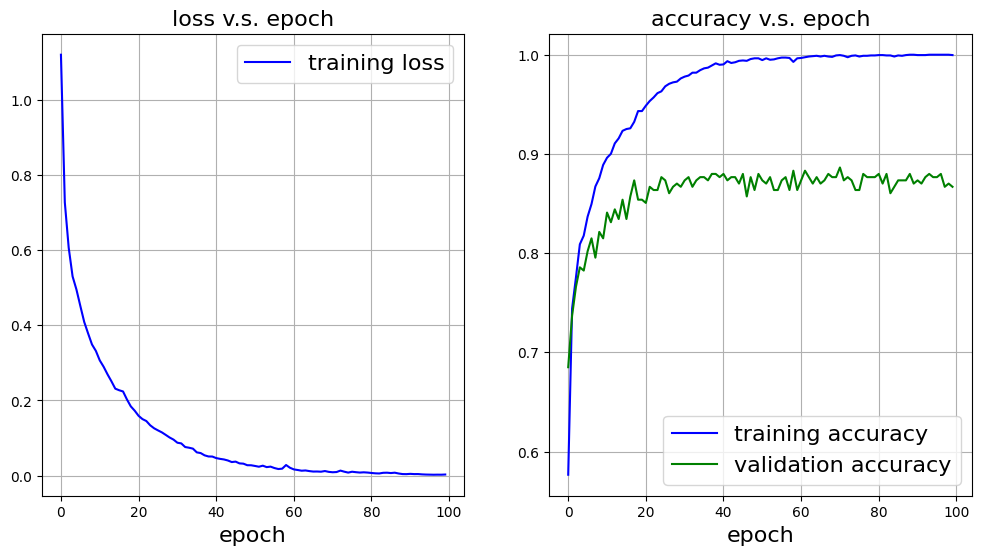

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [ ]:
best_epoch=np.argmax(acc_val_list)
best_epoch

70

In [ ]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

<ipython-input-38-7b68a2e167ca>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')


In [ ]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.91807544
Sensitivity [0.89204544 0.88961041 0.9041096  0.95901638 0.95321637]
Precision [0.86263734 0.88387096 0.94285715 0.9285714  0.98192769]
Confusion 
 [[157.  12.   3.   3.   1.]
 [ 13. 137.   3.   1.   0.]
 [  6.   1. 132.   5.   2.]
 [  4.   0.   1. 117.   0.]
 [  2.   5.   1.   0. 163.]]
